# **Importing Libraries**

In [178]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

In [179]:
#for classification/regression tasks and training on data sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [180]:
#for training deep learning models with Pytorch (with images)
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# **Loading Data**

In [181]:
#converts test submission, test data, training data, and target metadata name csvs to Pandas Dataframes
submission = pd.read_csv('/kaggle/input/planttraits2024/sample_submission.csv')
test_data = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
train_data =pd.read_csv('/kaggle/input/planttraits2024/train.csv')
target_name = pd.read_csv("/kaggle/input/planttraits2024/target_name_meta.tsv", delimiter='\t')

# **Sizing/Understanding Data**

In this section we wanted to understand how each individual image was sized to determine if a standardized resizing formula was necessary. Additionally, we sampled 9 images from the training and testing data to give us a better idea of the complexity of each image. We wanted to know if the images were taken in a standardized fashion.

In [182]:
# Define 'images_folder' as a string path to the Kaggle competition train_images
images_folder_path = '/kaggle/input/planttraits2024/train_images/'

# List all files in the 'images_folder' directory
image_files = os.listdir(images_folder_path)

# Count the number of images
num_images = len(image_files)

# Print the count of images
print(f"Number of images in the training data set: {num_images}")


Number of images in the training data set: 55489


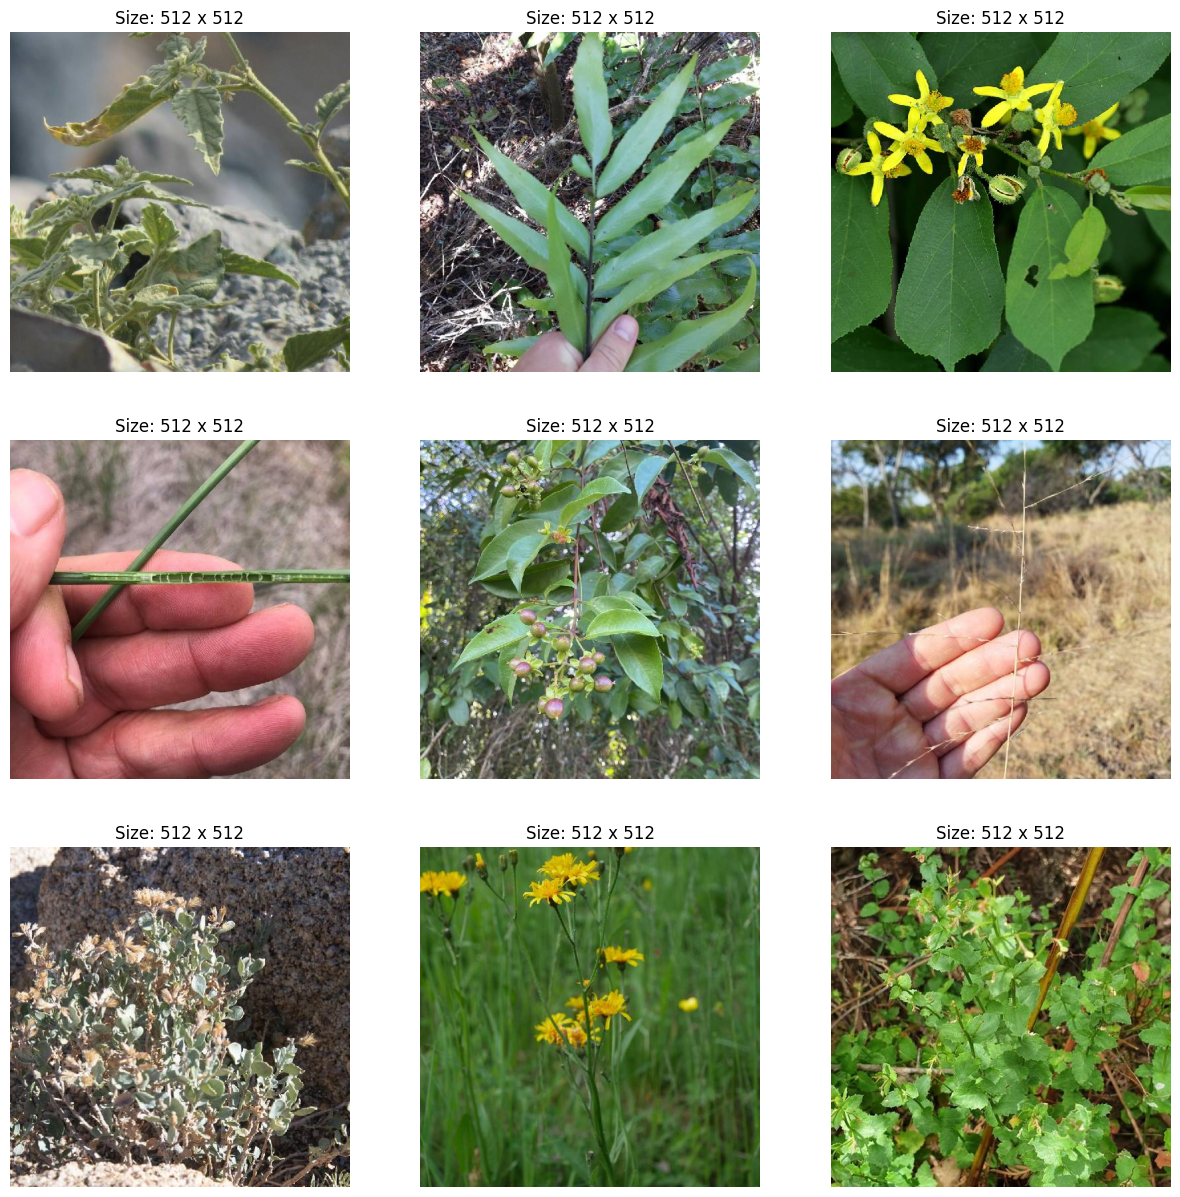

In [183]:
# Select nine random image files
random_images = random.sample(image_files, 9)

# Create a figure for displaying the images
plt.figure(figsize=(15, 15))  # Size of figure 

# Loop through the selected images
for i, image_file in enumerate(random_images):
    # Construct the full image path
    image_path = os.path.join(images_folder_path, image_file)
    
    # Open the image
    img = Image.open(image_path)
    
    # Get the size of the image
    original_size = img.size
    
    # Add a subplot in a 3x3 grid
    plt.subplot(3, 3, i + 1)
    
    # Display the image
    plt.imshow(img)
    
    # Set the title of each subplot to the dimensions of the image
    plt.title(f"Size: {original_size[0]} x {original_size[1]}")

    plt.axis('off')

plt.show()


In [184]:
#Set initial count to 0
count_non_512 = 0
#Ran a for loop that looked through all the images in the full path
for image_file in image_files:
    # Construct the full image path
    image_path = os.path.join(images_folder_path, image_file)
    
    #Test the following code block for errors
    try:
        
        img = Image.open(image_path)
        
        #Check if the image size is not 512x512
        if img.size != (512, 512):
            count_non_512 += 1
    except IOError:
        #Handle the error if the file is not an image
        print(f"Cannot open {image_file}")

#Print the total number of images not 512x512
print(f"Number of images not 512x512: {count_non_512}")



Number of images not 512x512: 0


This cell of code verified that all of the training imgaes in "train_images" are 512x512.

Same method as training images.

In [185]:
# Define 'images_folder_path' as a string path to the Kaggle competition test_images
images_folder_path = '/kaggle/input/planttraits2024/test_images/'

# List all files in the 'images_folder_path' directory
image_files = os.listdir(images_folder_path)

# Count the number of images
num_images = len(image_files)

# Print the count of images
print(f"Number of images in the test data set: {num_images}")


Number of images in the test data set: 7133


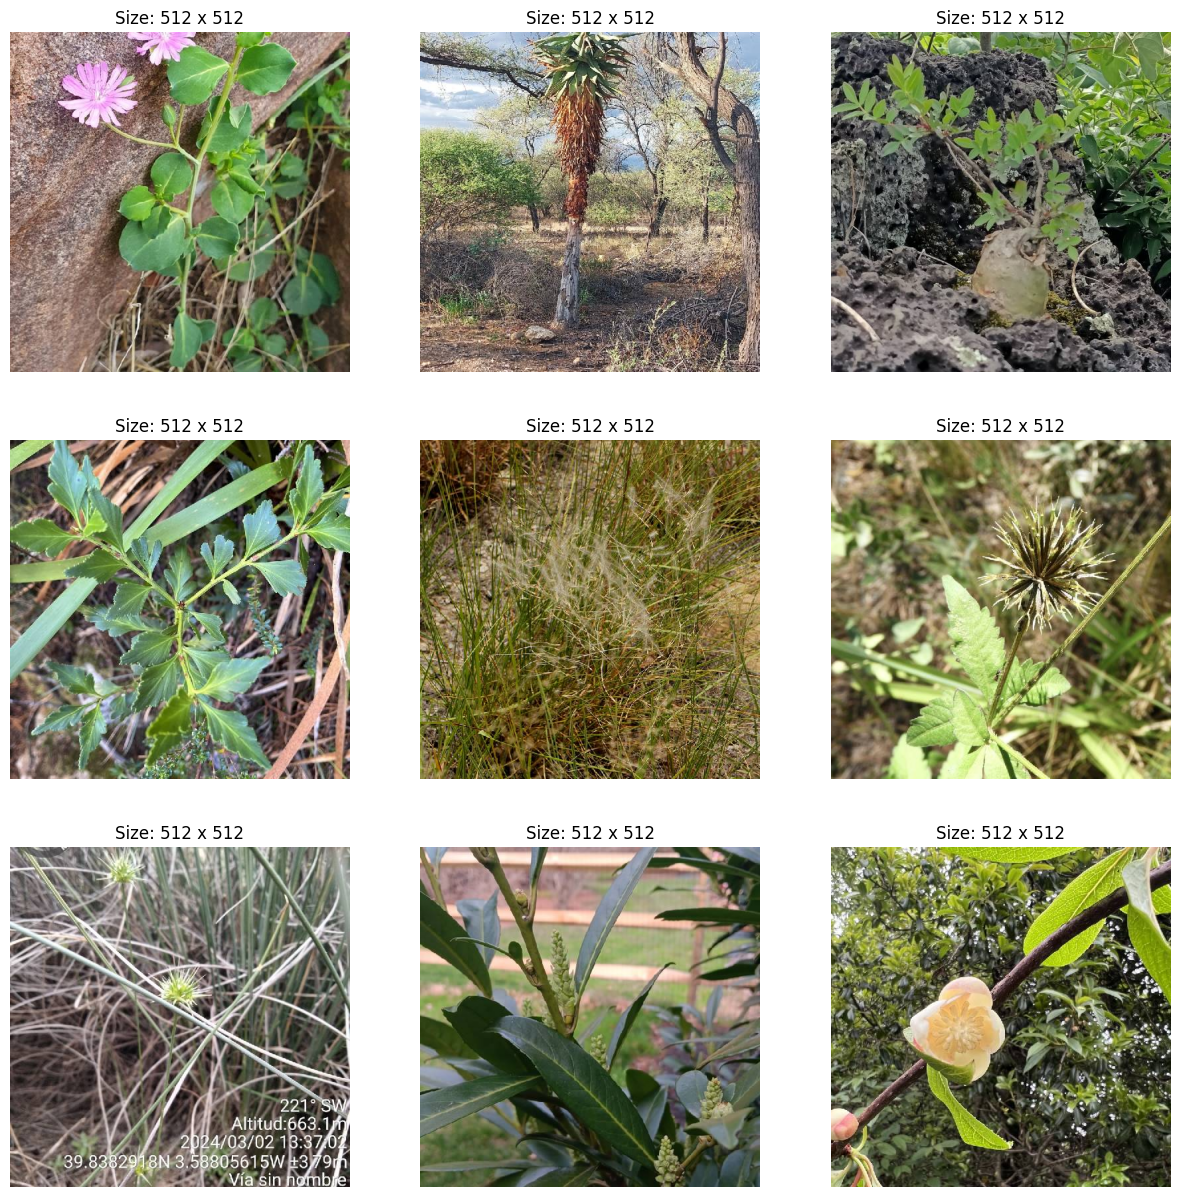

In [186]:
# Select nine random image files
random_images = random.sample(image_files, 9)

# Create a figure for displaying the images
plt.figure(figsize=(15, 15))  # Size of figure 

# Loop through the selected images
for i, image_file in enumerate(random_images):
    # Construct the full image path
    image_path = os.path.join(images_folder_path, image_file)
    
    # Open the image
    img = Image.open(image_path)
    
    # Get the size of the image
    original_size = img.size
    
    # Add a subplot in a 3x3 grid
    plt.subplot(3, 3, i + 1)
    
    # Display the image
    plt.imshow(img)
    
    # Set the title of each subplot to the dimensions of the image
    plt.title(f"Size: {original_size[0]} x {original_size[1]}")

    plt.axis('off')

plt.show()


In [187]:
#Set initial count to 0
count_non_512 = 0
#Ran a loop that looked at all images in path
for image_file in image_files:
    # Construct the full image path
    image_path = os.path.join(images_folder_path, image_file)
    
    # Test the following code block for errors
    try:
        
        img = Image.open(image_path)
        
        # Check if the image size is not 512x512
        if img.size != (512, 512):
            count_non_512 += 1
    except IOError:
        # Handle the error if the file is not an image
        print(f"Cannot open {image_file}")

# Print the number of images not 512x512
print(f"Number of images not 512x512: {count_non_512}")


Number of images not 512x512: 0


This cell verified that all the testing images in "test_image" are 512x512. We have now fully verified that all the images we are working with are the same size, so we do not need a standardized resizing formulation.

# **R^2 Formulation**

In [188]:
#defines the r^2 function: the metric by which the competition will grade the predictions
def calculate_mean_r2(actual_values, predicted_values):
    residual_sum_of_squares = np.sum((actual_values - predicted_values) ** 2, axis=0)
    total_sum_of_squares = np.sum((actual_values - np.mean(actual_values, axis=0)) ** 2, axis=0)
    
    
    r2_scores = 1 - residual_sum_of_squares / (total_sum_of_squares + 1e-6)
    #added a small number, 1e-6, to the denominator to ensure we won't divide by 0
    
    mean_r2_score = np.mean(r2_scores)
    
    return mean_r2_score

Maximizing the R^2 value is the goal for our model, since the Kaggle competition will grade our submission based on that metric.

# **Data Visualization**

In [189]:
actual_values_columns = train_data.filter(like='_mean').values

The cell above filters the "train_data" dataframe by any column containing the string 'mean.' These are going to be the y values for our prediction models, since these are the traits that we will be predicting

In [190]:
#select columns ending with '_mean' as target columns
train_y_columns = [col for col in train_data.columns if col.endswith('_mean')]
#select columns not ending with ('_sd', '_mean') as feature columns
train_X_columns = [col for col in train_data.columns if not col.endswith(('_sd', '_mean'))]
#extract target values from the datase and store them in "y"
y = train_data[train_y_columns]
#extract feature values from the dataset,store them in "x", and drop the 'id' column
X = train_data[train_X_columns].drop(['id'], axis=1)


The cell above creates target and feature columns from the training data. This allows us to create graphs and correlation charts based on the relation of these target columns to each feature.

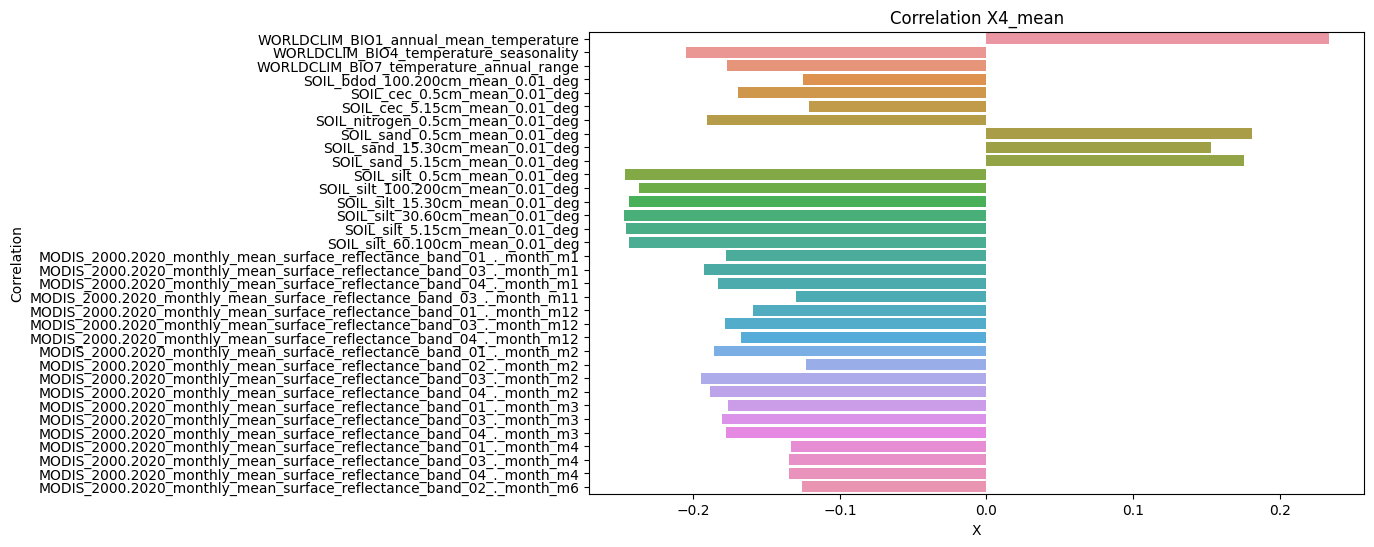

No correlation greater than 0.12 for X11_mean
No correlation greater than 0.12 for X18_mean
No correlation greater than 0.12 for X26_mean
No correlation greater than 0.12 for X50_mean
No correlation greater than 0.12 for X3112_mean


In [191]:
#Ran a for loop that looks at each target column and creates a correlation matrix for the relevant features
for target_col in train_y_columns:
    target = y[target_col]
    
    corr_matrix = X.corrwith(target)
    #Relevant features described as anything with a correlation of greater than or equal to 0.12
    relevant_features = corr_matrix[abs(corr_matrix) >= 0.12]
    #An error check for the situation that there are no "relevant features" in the dataset
    if len(relevant_features) == 0:
        print("No correlation greater than 0.12 for", target_col)
    else:
        #Plotting information
        plt.figure(figsize=(10, 6))
        sns.barplot(x=relevant_features.values, y=relevant_features.index, orient='h')
        plt.title(f'Correlation {target_col}')
        plt.xlabel('X')
        plt.ylabel('Correlation')
        plt.show()

In [192]:
#Next we looked at creating an array of the top 15 features that are correlated with each target column
for target_col in train_y_columns:
    print(f"Selecting top 15 features for target column: {target_col}")
    #Used a KBest selector to score the top 15 features and displays them in an array
    selector = SelectKBest(score_func=f_regression, k=15)
    X_selected = selector.fit_transform(X, y[target_col])

    selected_indices = selector.get_support(indices=True)
    
    selected_features = X.columns[selected_indices]
    print("Selected features:", selected_features)
    print()

Selecting top 15 features for target column: X4_mean
Selected features: Index(['WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'SOIL_nitrogen_0.5cm_mean_0.01_deg', 'SOIL_sand_0.5cm_mean_0.01_deg',
       'SOIL_silt_0.5cm_mean_0.01_deg', 'SOIL_silt_100.200cm_mean_0.01_deg',
       'SOIL_silt_15.30cm_mean_0.01_deg', 'SOIL_silt_30.60cm_mean_0.01_deg',
       'SOIL_silt_5.15cm_mean_0.01_deg', 'SOIL_silt_60.100cm_mean_0.01_deg',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m2',
       'MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m2'],
      dtype='object')

Selecting top 15 features for target column: X11_mean
Selected features: Index(['SOIL_bdod_0.5cm_mean_0.01_d

In [193]:
#Creates a variable that converts the extracted feature values from "X" to a list
cols = X.columns.tolist()

#Extracts the first two words from each column name
first_two_words = ['_'.join(col.split('_')[:2]) for col in cols]

#Initializes an empty dictionary to store sorted columns
sorted_cols = {}

#Ran a look that groups columns based on their first two words
for col, first_two_word in zip(cols, first_two_words):
    if first_two_word not in sorted_cols:
        sorted_cols[first_two_word] = [col]
    else:
        sorted_cols[first_two_word].append(col)
        
#Prints sorted columns
for first_two_word, cols in sorted(sorted_cols.items()):
    print(f'{first_two_word}:')
    for col in cols:
        print(f'  - {col}')


MODIS_2000.2020:
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m1
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m1
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m1
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m1
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m1
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m10
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m10
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m10
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_._month_m10
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_._month_m10
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_._month_m11
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_._month_m11
  - MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_._month_m11
  - MODIS_2000.2020_monthly_mean_surfac

This cell gave us a comprehensive list of the features found in the features data. This allowed us to be able to reference specific features for additional graphs later in the project.

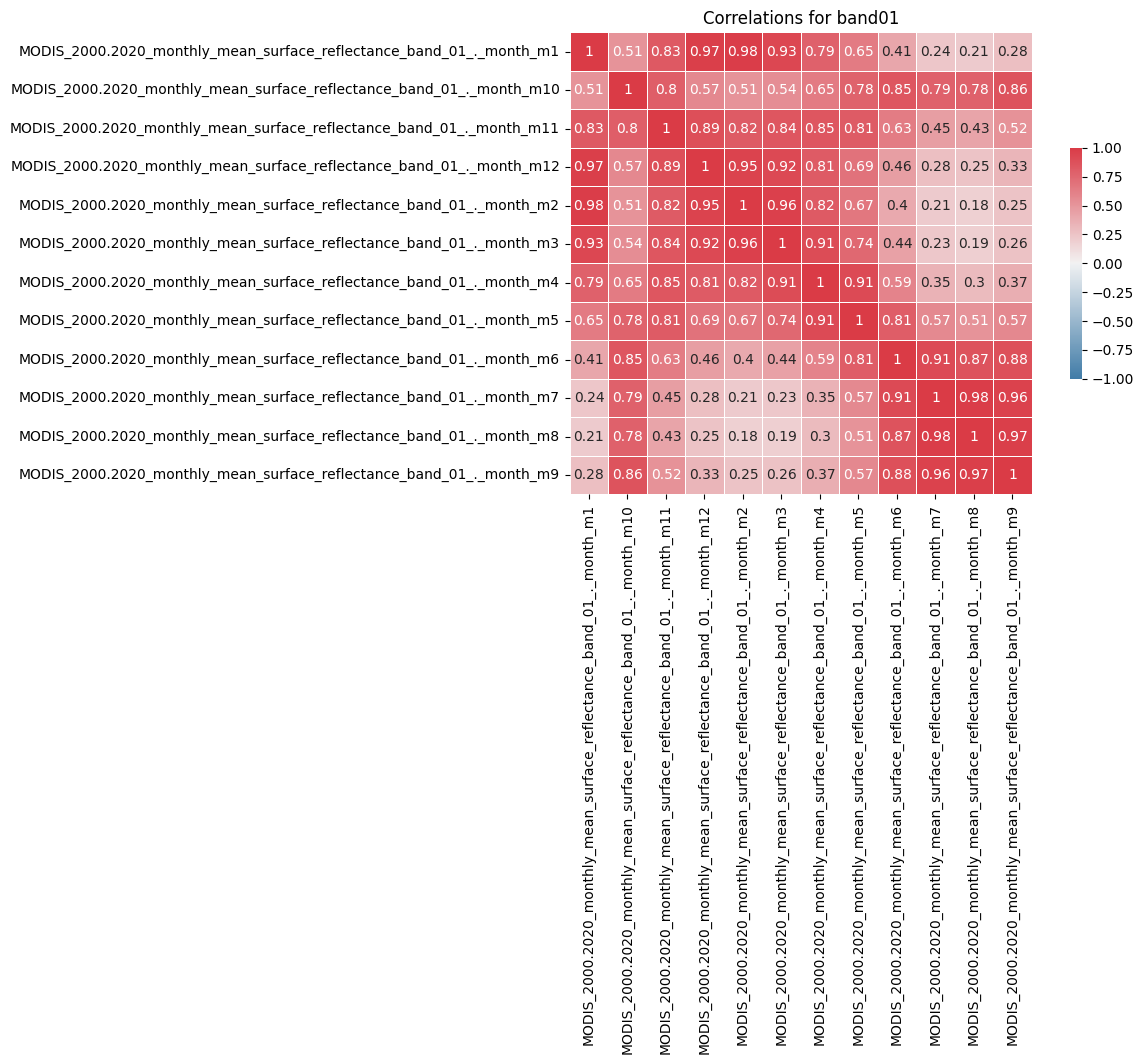

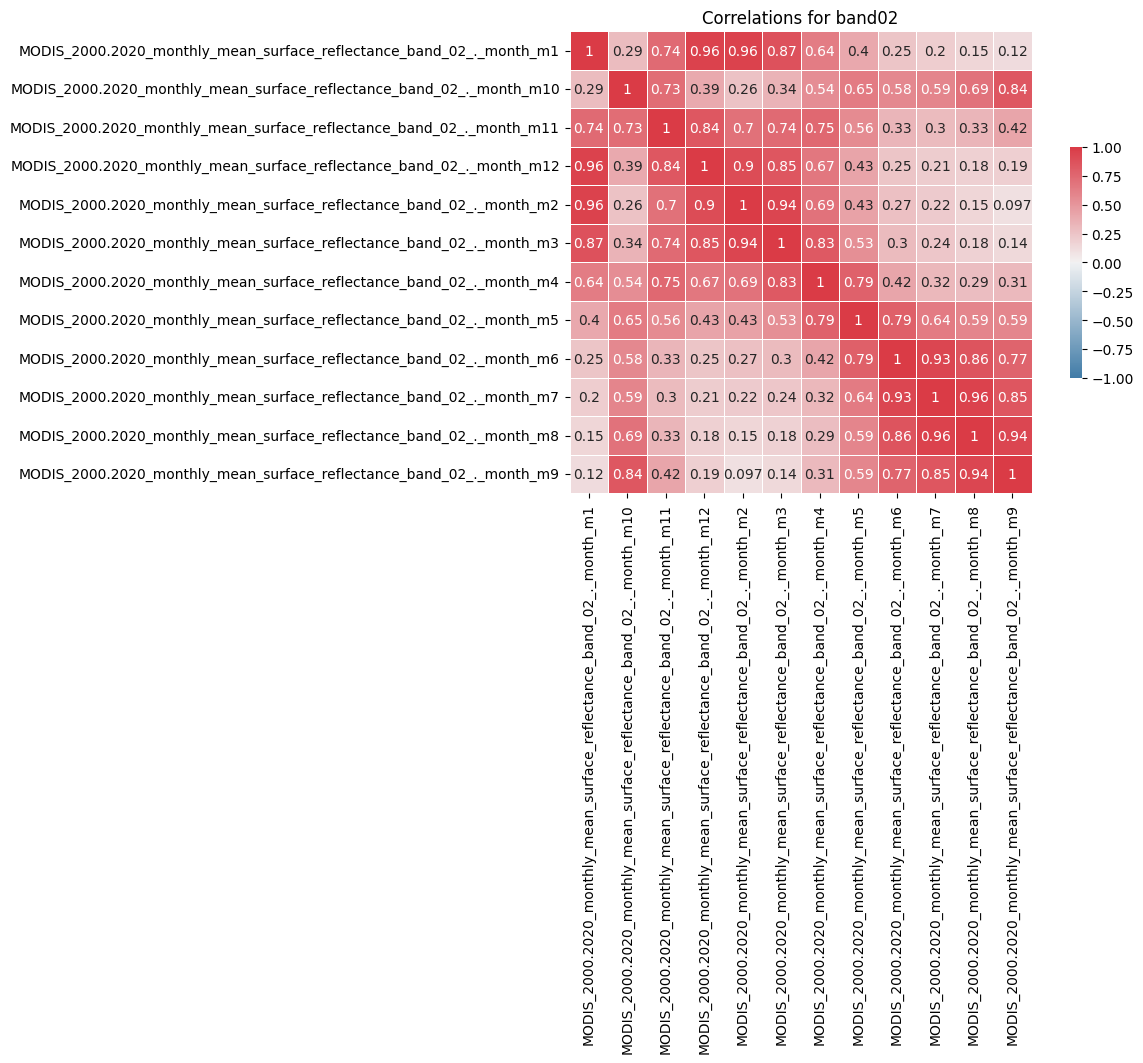

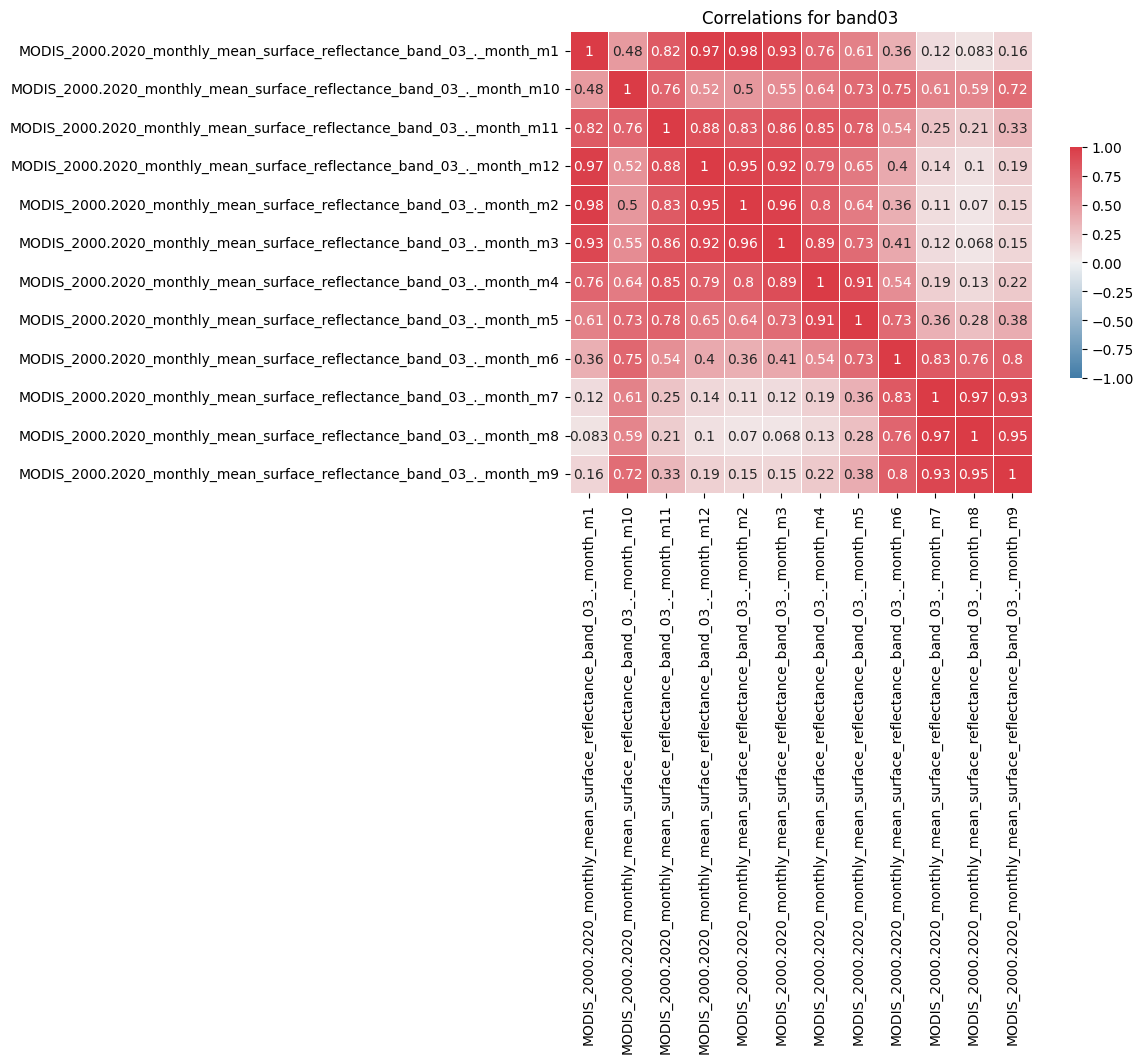

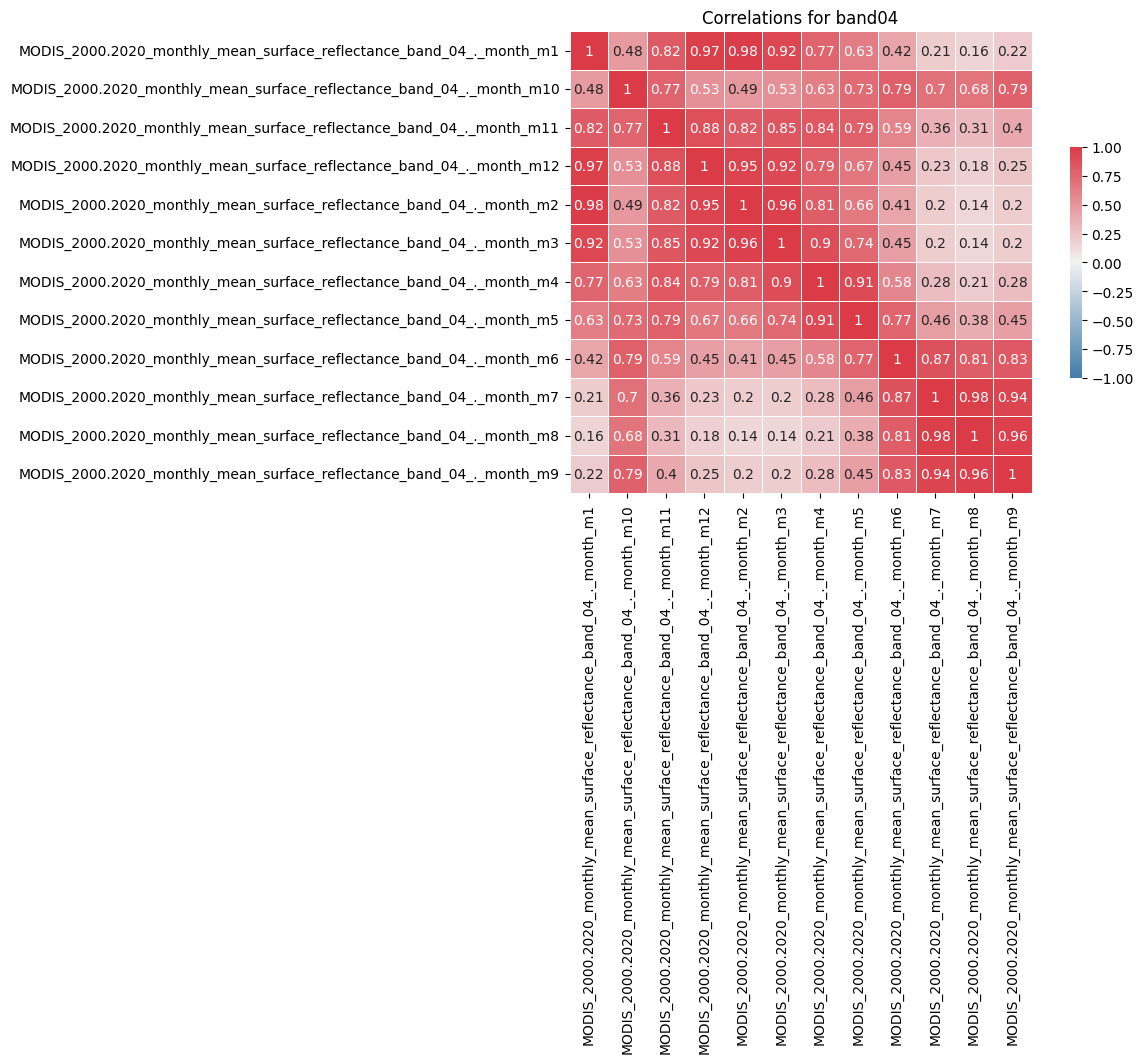

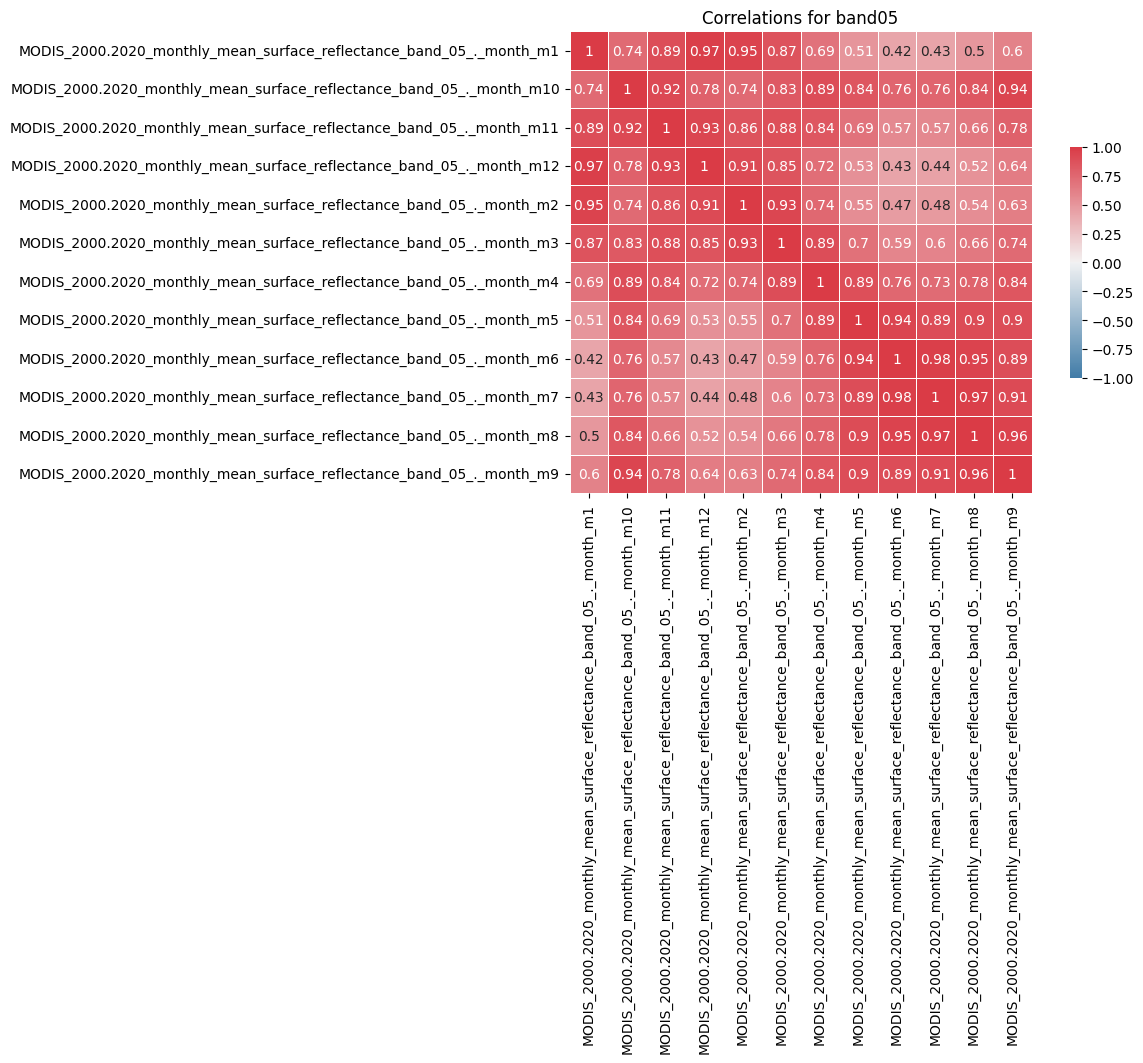

In [194]:
#Evaluating the Correlations for created bands for the MODIS feature
groups = {
    "band01": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_01_" in col],
    "band02": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_02_" in col],
    "band03": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_03_" in col],
    "band04": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_04_" in col],
    "band05": [col for col in X.columns if "MODIS_2000.2020_monthly_mean_surface_reflectance_band_05_" in col],
}
#Ran a loop to iterate over each group
for group_name, group_cols in groups.items():
    #Create a correlation matrix for the group
    corr_matrix = X[group_cols].corr(method='pearson')
    #Create a mask for values with correlations above 0.7
    mask = (corr_matrix.abs() > 0.7)
    
    #Plotting details(correlation matrix as a heatmap)
    plt.figure(figsize=(10, 6))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.title(f"Correlations for {group_name}")
    plt.show()


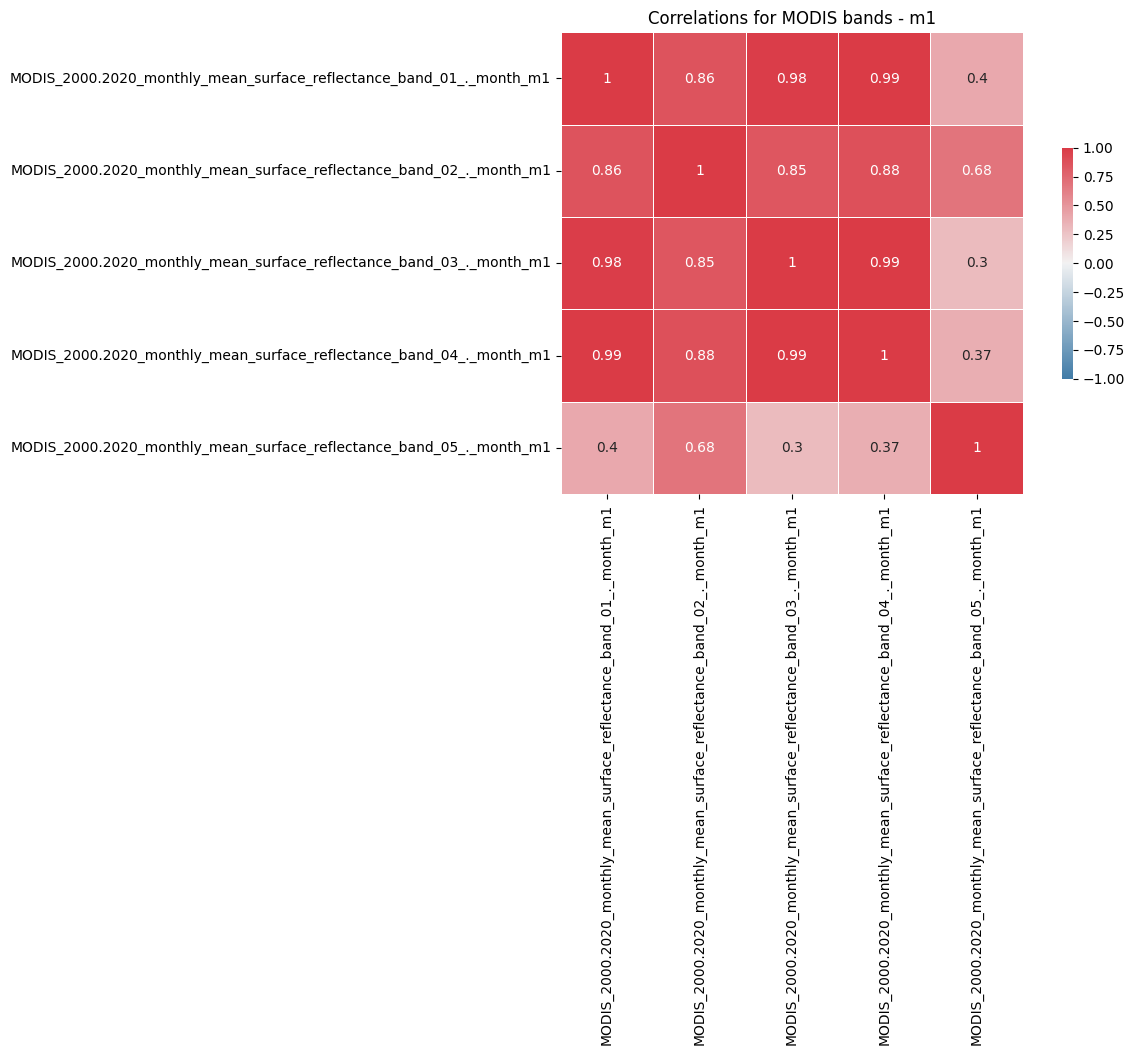

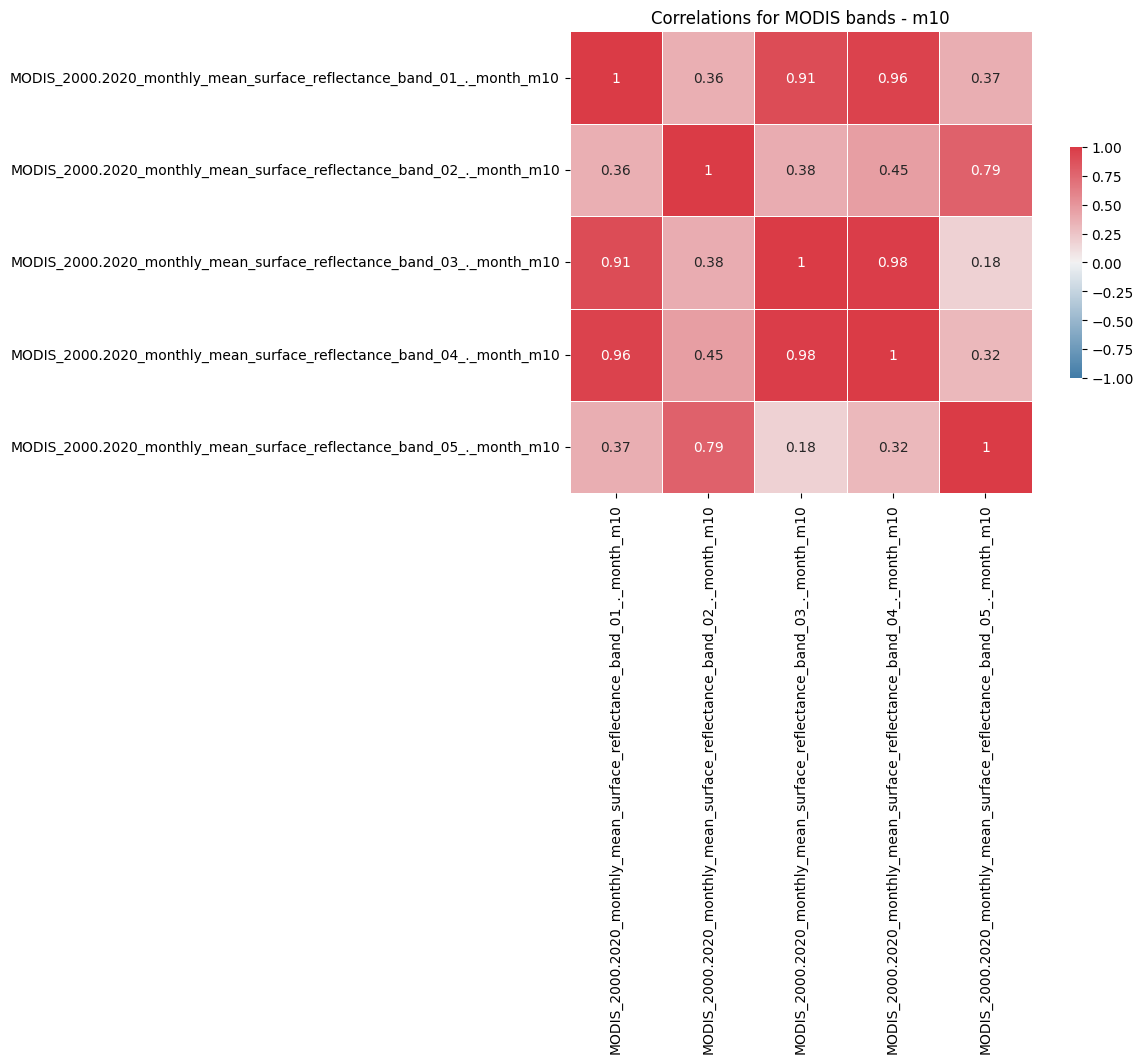

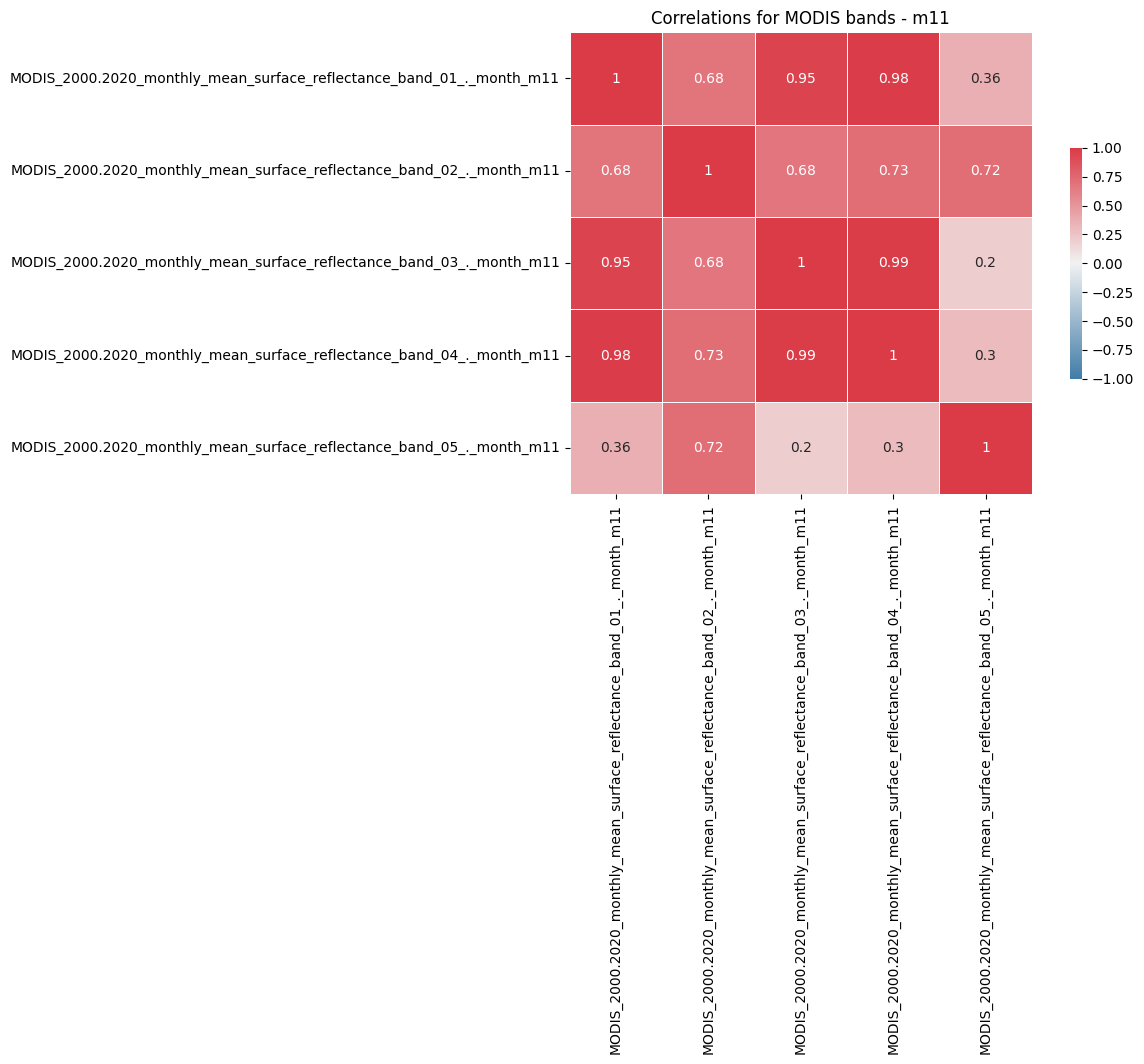

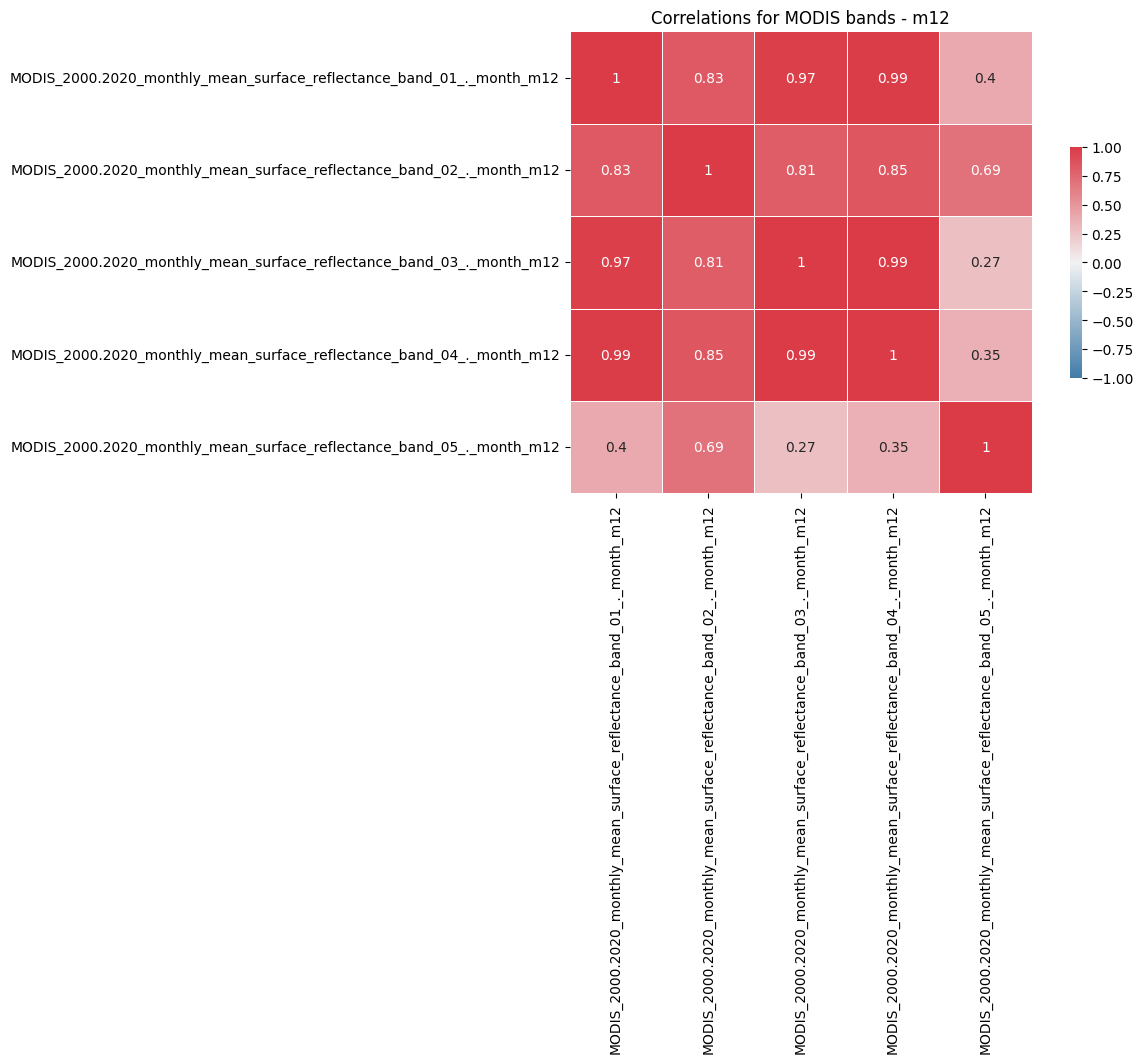

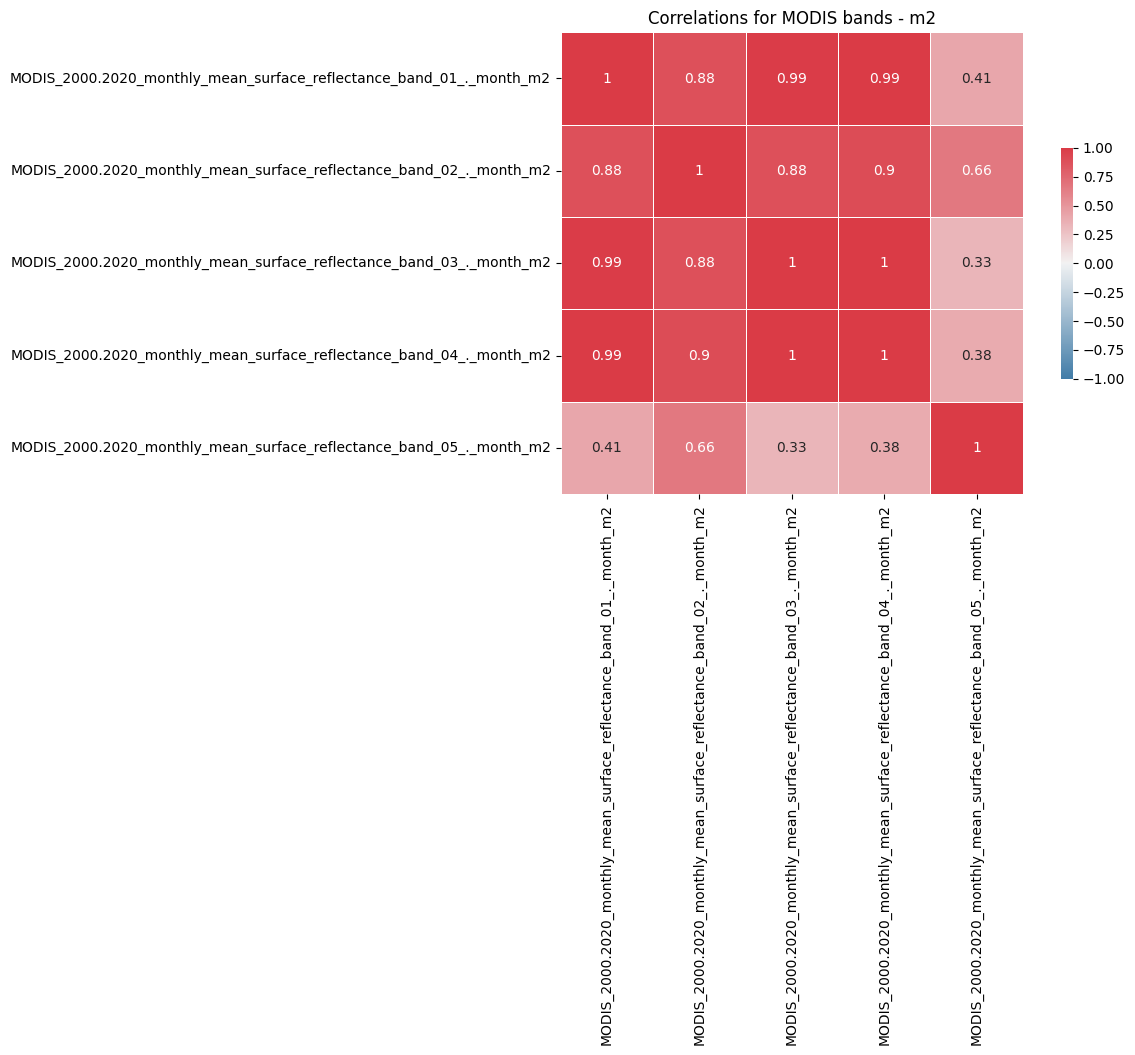

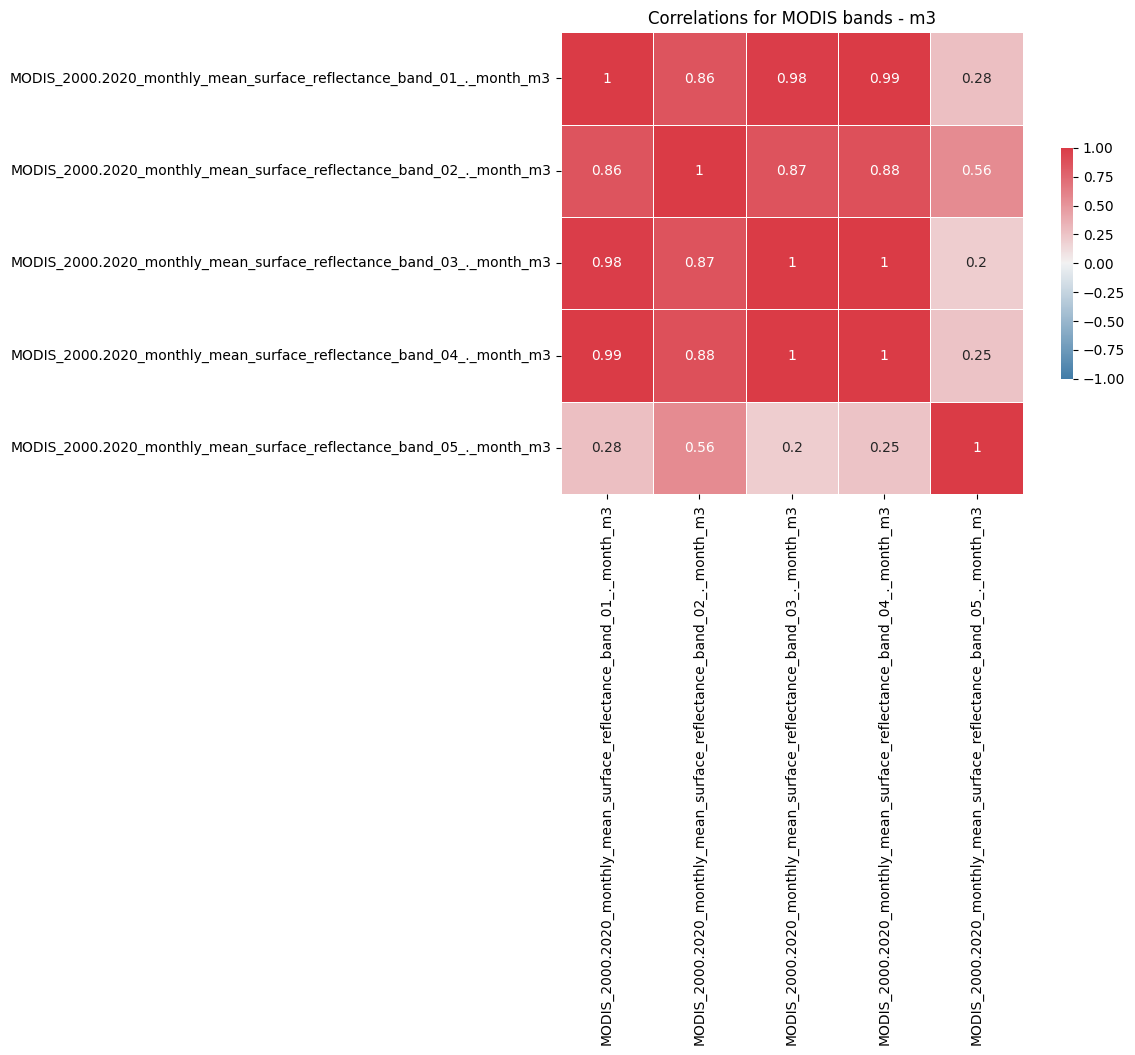

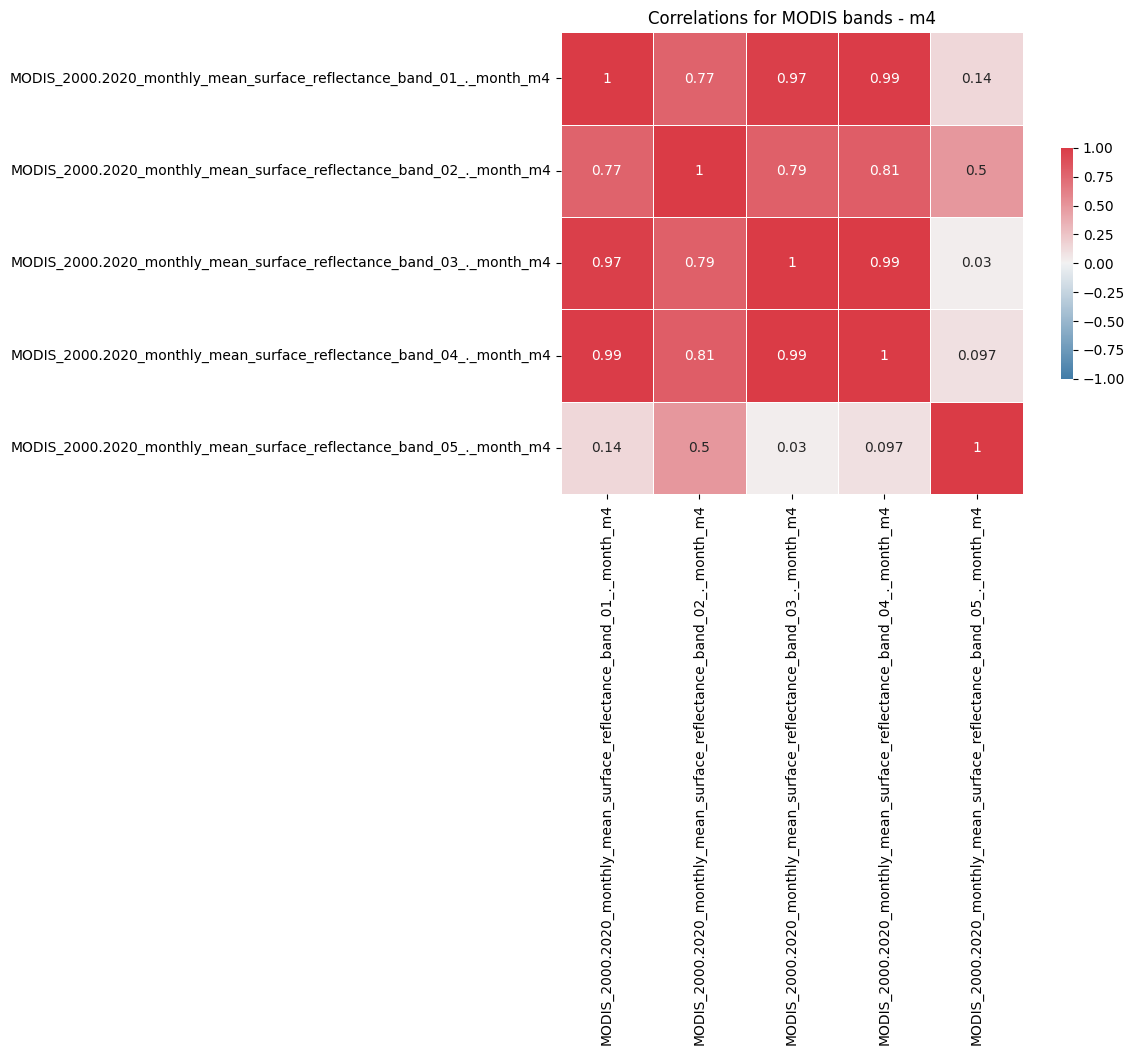

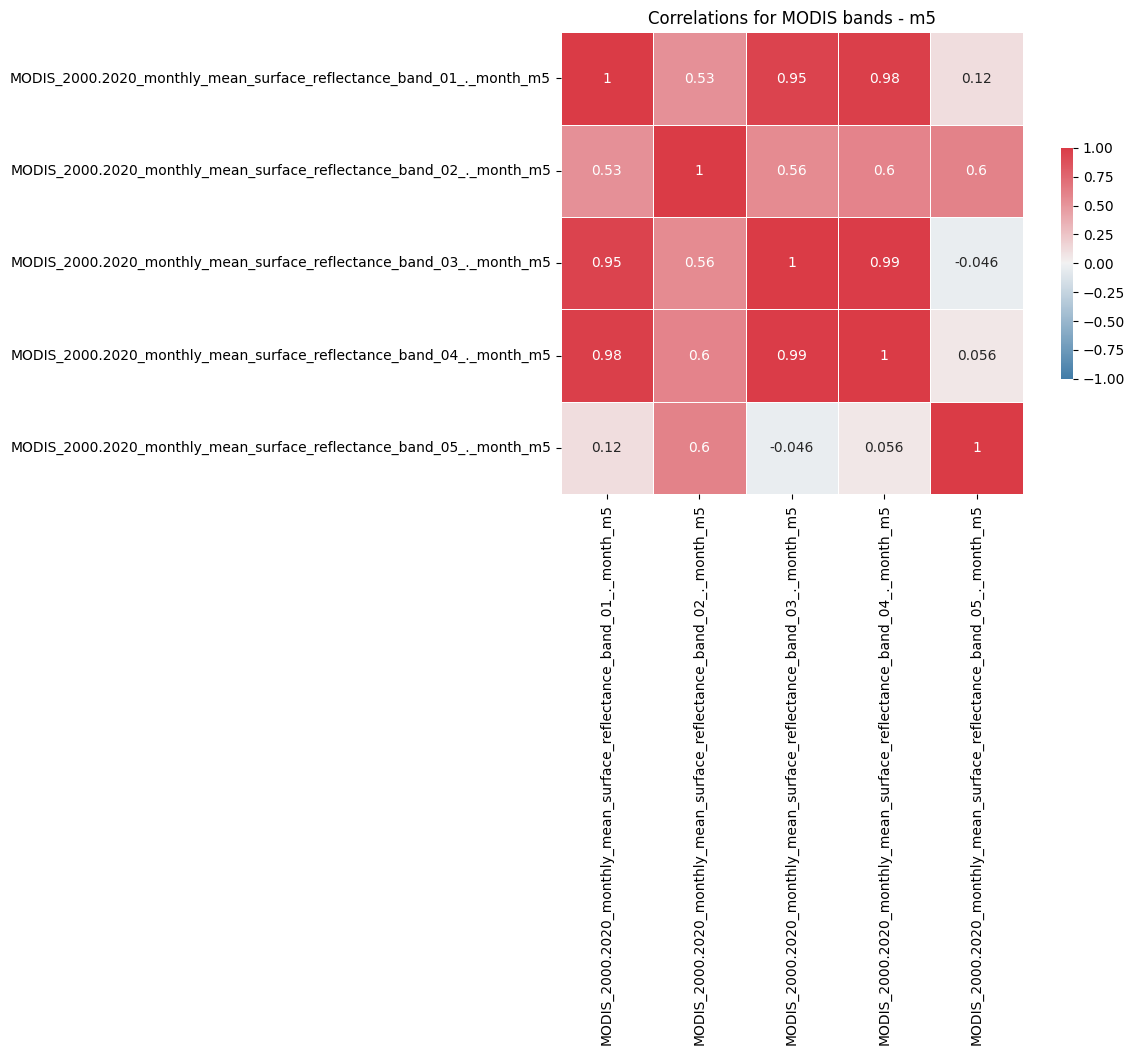

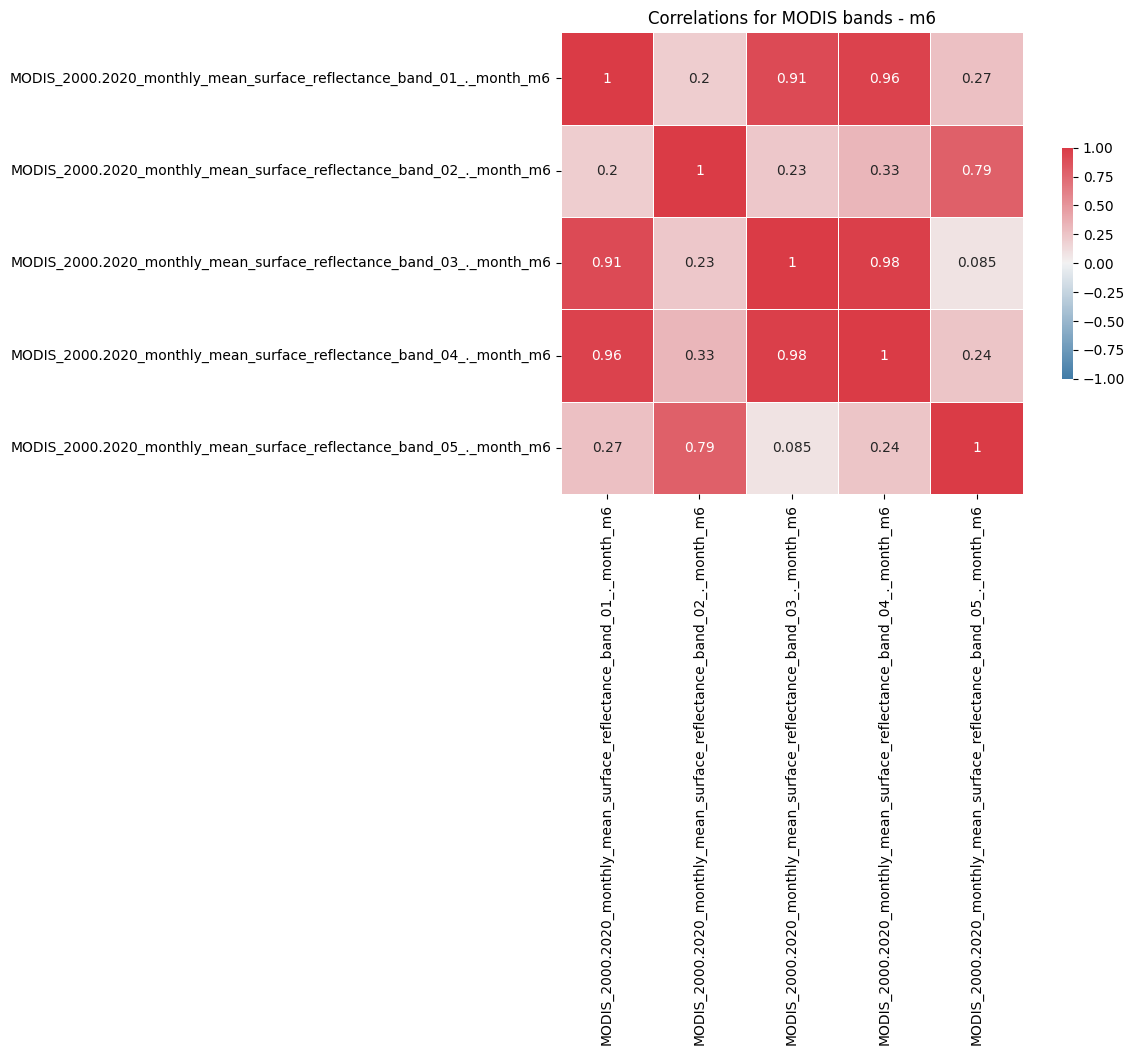

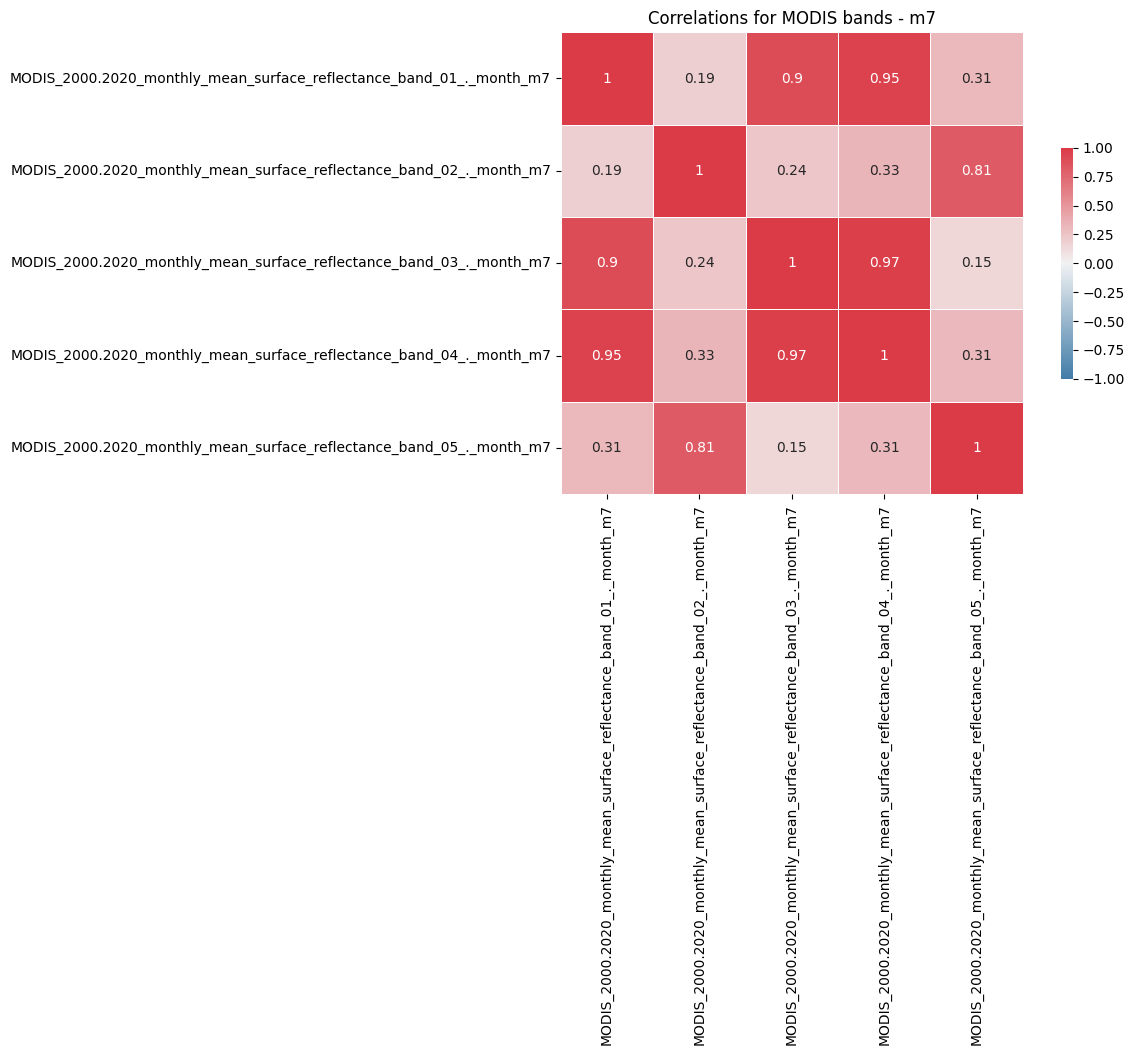

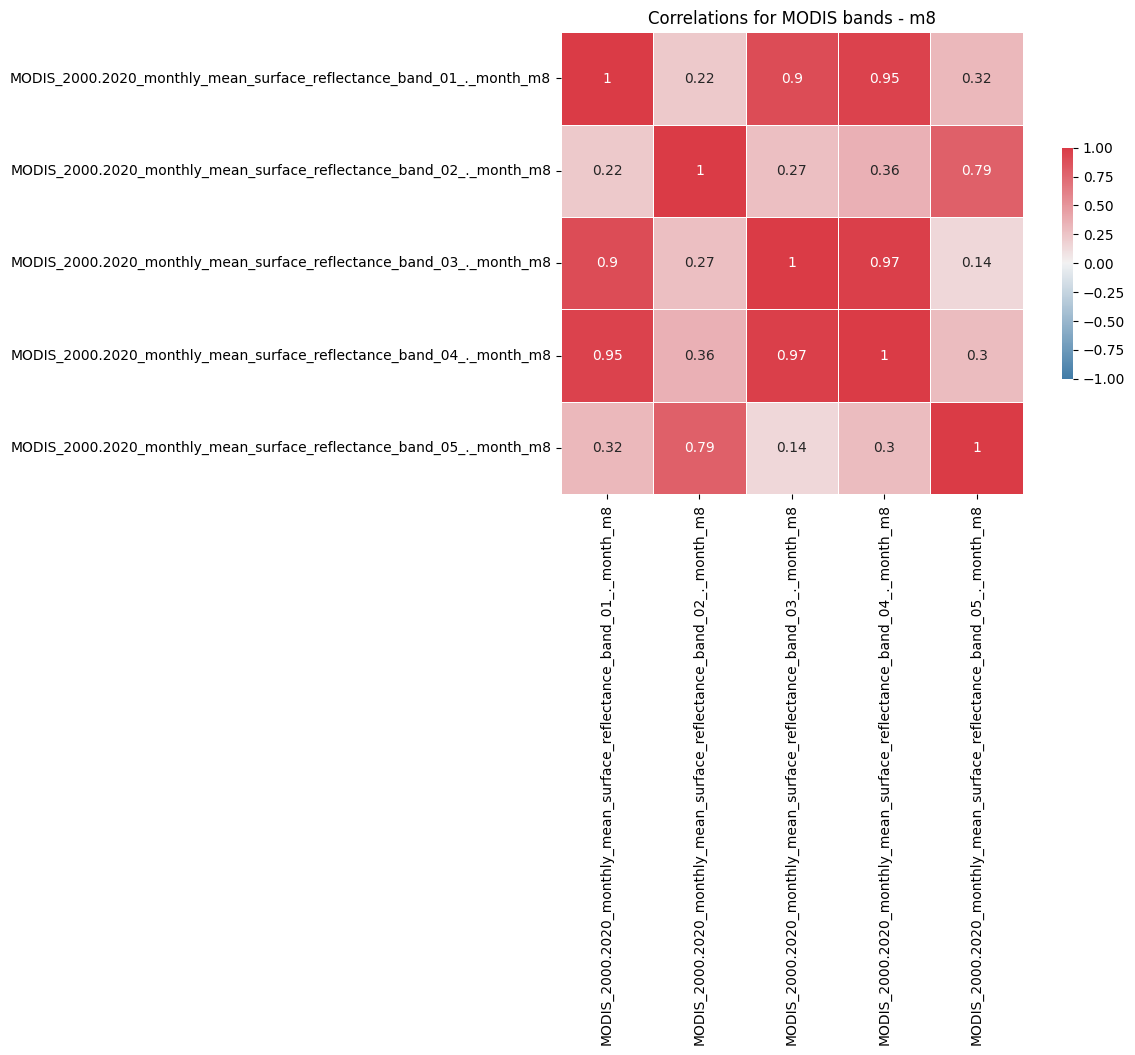

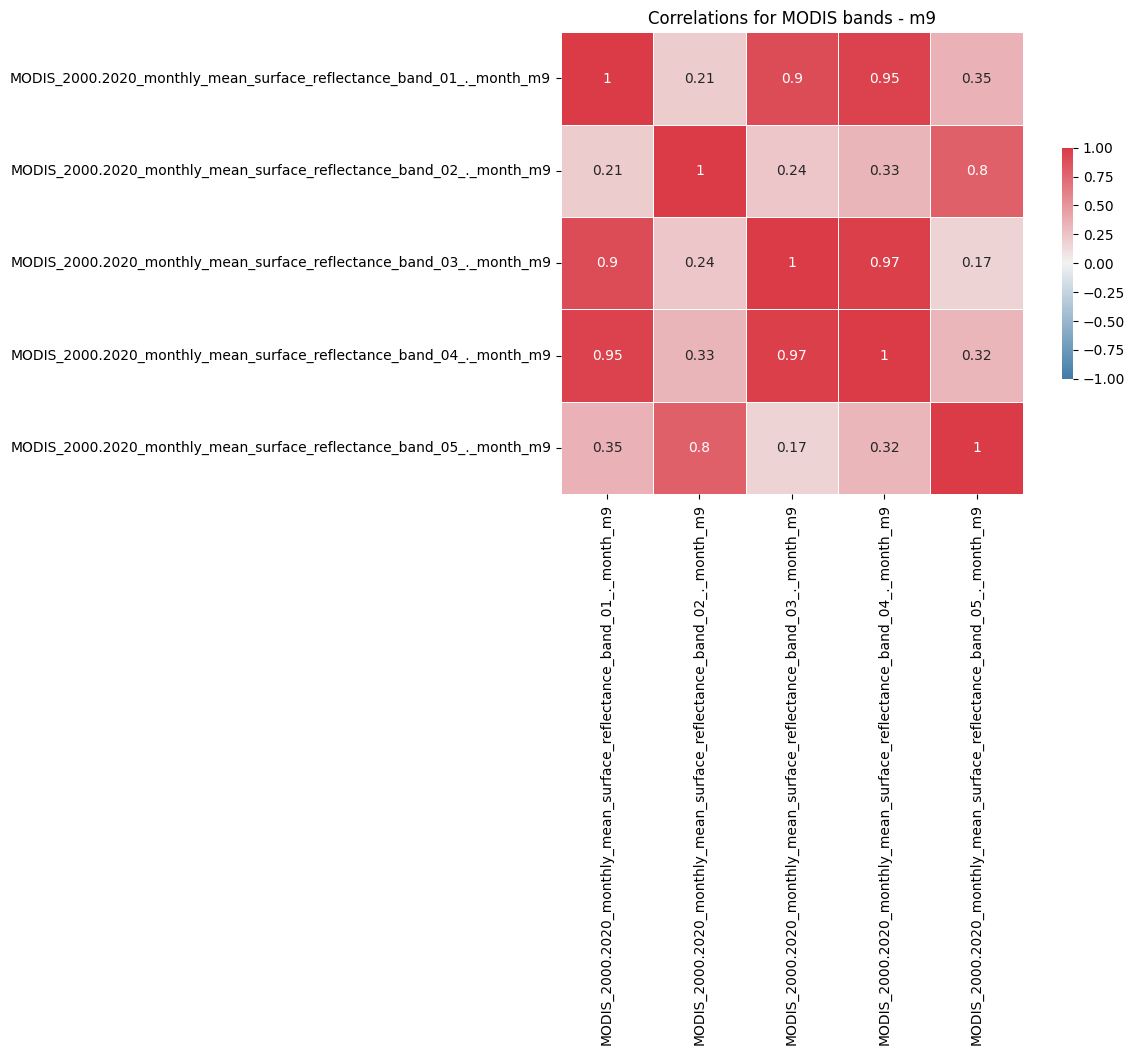

In [195]:
#Set the "groups" variable to be an empty dictionary
groups = {}

#Ran a loop for all columns in "X"
for col in X.columns:
    #Check if the column name starts with 'MODIS_'
    if col.startswith('MODIS_'):
        #Extract the month from the column name
        month = col.split('_')[-1]
        #Add the column to the corresponding month group in the dictionary
        if month in groups:
            groups[month].append(col)
        else:
            groups[month] = [col]

#Creates a correlation matrix for each group
for month, cols in groups.items():
    #Create a correlation matrix for the group
    corr_matrix = X[cols].corr(method='pearson')
    #Create a mask for values with correlations above 0.7
    mask = (corr_matrix.abs() > 0.7)
    
    #Plotting details
    plt.figure(figsize=(10, 6))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.title(f"Correlations for MODIS bands - {month}")
    plt.show()


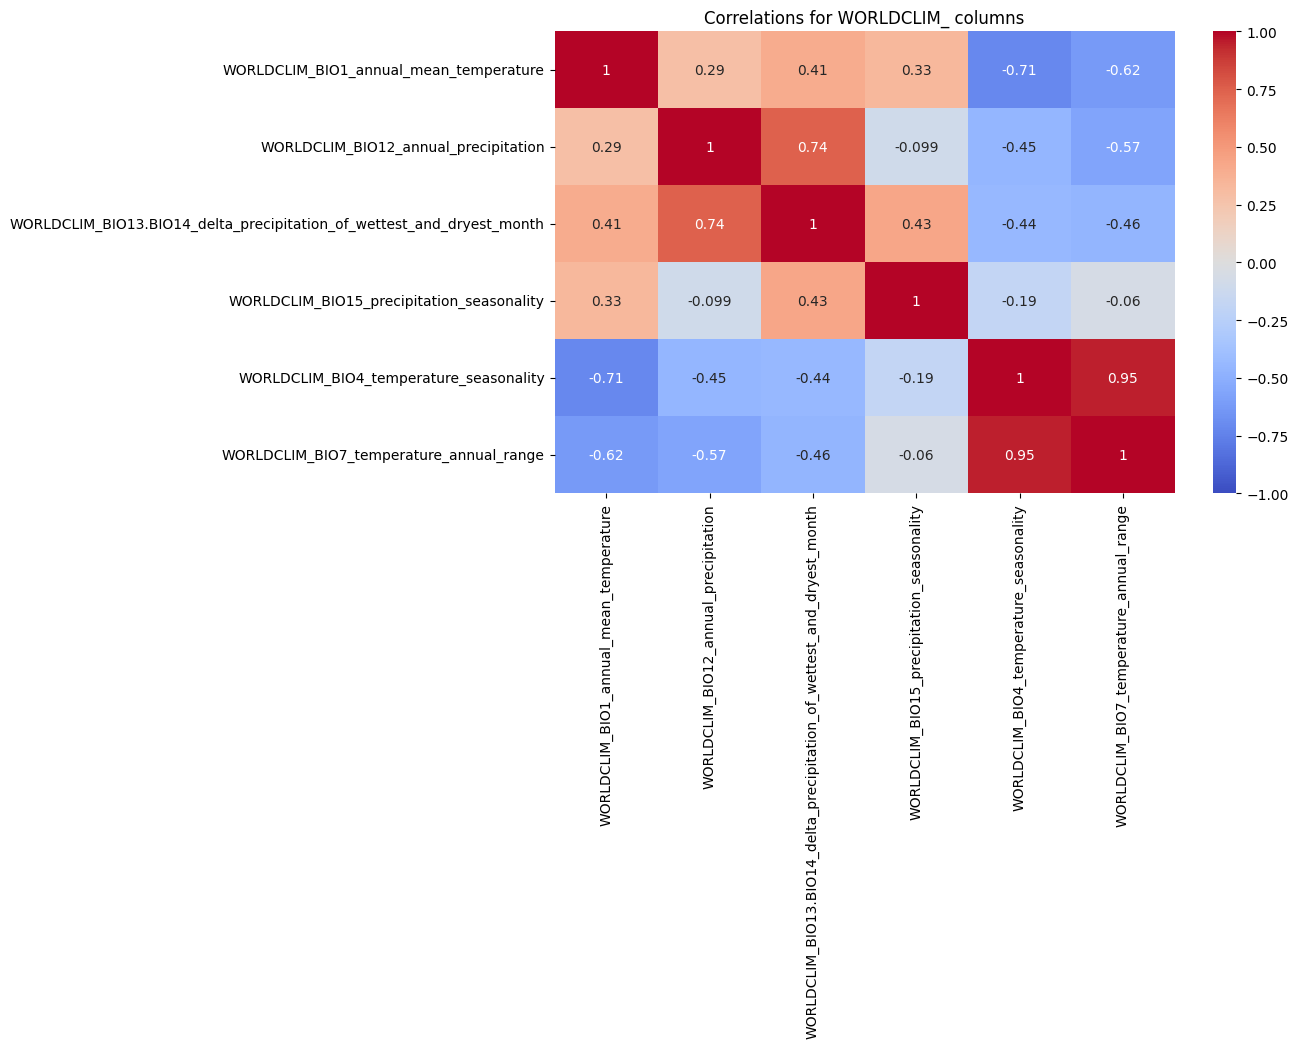

In [196]:
#Creating a Correlation matrix for the WORLDCLIM_ columns
worldclim_cols = [col for col in X.columns if col.startswith('WORLDCLIM_')]
corr_matrix = X[worldclim_cols].corr()

#Plotting details
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlations for WORLDCLIM_ columns")
plt.show()

# **Data Preparation for Modeling**

In [197]:
#Filter groups based on the number of columns in each group
filtered_columns = {key: val for key, val in sorted_cols.items() if 1 < len(val) <= 30}

#Iterate over each filtered group
for group_name, group_columns in filtered_columns.items():
    #Calculate the mean features for each group and create a new column in X
    #Calculate the mean along the columns for each group
    mean_features = X[group_columns].mean(axis=1)
    #Create a new column in X with the mean features for the group
    X[f'{group_name}_mean_features'] = mean_features


In [198]:
#Ran a loop to iterate over each group
for month, cols in groups.items():
    #Select columns belonging to the current group
    X_group = X[cols]
    
    #Standardize the data for the current group
    scaler = StandardScaler()
    X_group_normalized = scaler.fit_transform(X_group)
    
    #Perform PCA with one component for dimensionality reduction
    pca = PCA(n_components=1)
    X_group_pca = pca.fit_transform(X_group_normalized)
    
    #Create a DataFrame to hold the PCA features
    X_group_pca = pd.DataFrame(X_group_pca, columns=[f'{month}_PCA_features'])
    
    #Concatenate the PCA features with the original DataFrame X
    X = pd.concat([X, X_group_pca], axis=1)


In [199]:
#Define the columns we are using in our final prediction
desired_columns = [
    'WORLDCLIM_BIO1_annual_mean_temperature',
    'WORLDCLIM_BIO12_annual_precipitation',
    'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
    'WORLDCLIM_BIO15_precipitation_seasonality',
    'WORLDCLIM_BIO4_temperature_seasonality'
]

#Select feature columns that end with '_features'
features_columns = [col for col in X.columns if col.endswith('_features')]

#Combine desired columns with feature columns
selected_columns = desired_columns + features_columns

#Select only the desired columns from the DataFrame X
X = X[selected_columns]


In [200]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=50)

We split the data into the training and testing splits. The threshold we used was 0.1 so we had 90 percent of the data for training and 10 percent for testing. The random state variable ensures reproducibility of the the split.

In [201]:
class R2Loss(torch.nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, y_true, y_pred):
        SS_res = torch.sum((y_true - y_pred)**2, axis=0)
        SS_tot = torch.sum((y_true - torch.mean(y_true, axis=0))**2, axis=0)
        r2_loss = SS_res / (SS_tot + 1e-6)
        return torch.mean(r2_loss)
    
class R2Metric(torch.nn.Module):
    def __init__(self):
        super(R2Metric, self).__init__()
        self.SS_res = torch.zeros(6).to(device)
        self.SS_tot = torch.zeros(6).to(device)
        self.num_samples = torch.zeros(6).to(device)

    def update_state(self, y_true, y_pred):
        SS_res = torch.sum((y_true - y_pred)**2, axis=0)
        SS_tot = torch.sum((y_true - torch.mean(y_true, axis=0))**2, axis=0)
        self.SS_res += SS_res
        self.SS_tot += SS_tot
        self.num_samples += y_true.shape[0]

    def forward(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return torch.mean(r2)
    
    def reset_states(self):
        self.SS_res = torch.zeros(6).to(device)
        self.SS_tot = torch.zeros(6).to(device)
        self.num_samples = torch.zeros(6).to(device)

This cell draws our R^2 Loss Function and our R^2 Metric. These are both class modules drawn from the PyTorch library. The loss function calculates the R^2 loss based on the true label: "y_true" and predicted labels: "y_pred". The metric updates the state with new predictions and labels: "update_state" and computes the metric based on the accumulated state: "forward" and resetting the state "reset_states".

In [202]:
class Regressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, output_size)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        return x

This cell defines the neural network model we will be using under the name "Regressor". The details of the neural network are found below the "Regressor" class module. The variables "self.fc1", "self.fc2", and "self.fc3" define the fully connected layers of teh neural network. The first layer takes a size, input_size, and outputs a tensor of size 64. The second layer takes an input size of 64 and outputs a tensor of size 32. Finally, the third layer takes an input size of 32, and outputs a tensor of size "output_size". Meanwhile, the "self.relu" varialbes are indicators that define the ReLU actiation fucntions that introduc non-linearity to each layer of the model.

The "forward" method specifies how input data flows through the network. As we have seen in the previous part it flows with ReLU activation from fc1-fc2-fc3.

In [203]:
scaler_data = StandardScaler()
X_train_scaled = scaler_data.fit_transform(X_train)
X_val_scaled = scaler_data.transform(X_val)

train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train.values).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val_scaled).float(), torch.tensor(y_val.values).float())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

This cell prepares the data for training and validation. The StandardScaler, from PyTorch, standardizes the features by removing the mand and scaling to unit variance. The next few lines define how the training data and validation data is transformed by the scaler. From this the trained data is used to create the tensor datasets which are utilized for further usage. This was created for the training and validation data.

In [204]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Regressor(input_size=X_train.shape[1], output_size=6).to(device)
criterion = R2Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cpu


This cell initalizes the regression model, defines the loss function, and sets up our optimizer. We start with selecting the device "cuda" under the PyTorch library for training. Next we initalize the regression model with appropriate input and output sizes. The loss function is then assigned to a varible name to be referenced later during training. Finally, we set up our optimizer. We chose Adam due to its superior flexibility, robustness, and adaptive learning rate. Part of our project includes testing different learning rates to see the effect on R^2 values.(See graphs in report).

Epoch [1/10], Train R^2: -0.0214, Val R^2: -0.0027
Epoch [2/10], Train R^2: -0.0002, Val R^2: -0.0001
Epoch [3/10], Train R^2: 0.0010, Val R^2: 0.0026
Epoch [4/10], Train R^2: 0.0017, Val R^2: 0.0028
Epoch [5/10], Train R^2: 0.0021, Val R^2: -0.0013
Epoch [6/10], Train R^2: 0.0028, Val R^2: 0.0029
Epoch [7/10], Train R^2: 0.0020, Val R^2: 0.0040
Epoch [8/10], Train R^2: 0.0012, Val R^2: 0.0018
Epoch [9/10], Train R^2: 0.0033, Val R^2: 0.0027
Epoch [10/10], Train R^2: 0.0036, Val R^2: 0.0034


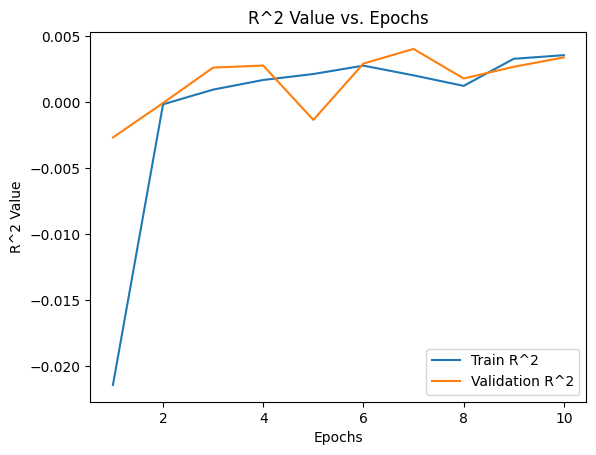

In [205]:
num_epochs = 10
train_r2_values = []
val_r2_values = []
r2_metric = R2Metric().to(device)

#Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_samples_train = 0
    r2_metric.reset_states()  #Resetting the R-squared metric for each epoch
   
    for x_batch, y_batch in train_loader:
        #Training steps...
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(y_batch, outputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        r2_metric.update_state(y_batch, outputs)
        total_samples_train += y_batch.size(0)

    train_r2 = r2_metric()
    train_r2_values.append(train_r2)
   
    # Validation loop
    model.eval()
    total_val_loss = 0
    total_samples_val = 0
    r2_metric.reset_states()
   
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            #Validation steps...
            outputs = model(x_batch)
            val_loss = criterion(y_batch, outputs)
            total_val_loss += val_loss.item()
            r2_metric.update_state(y_batch, outputs)
            total_samples_val += y_batch.size(0)

    val_r2 = r2_metric()
    val_r2_values.append(val_r2)
   
    print(f"Epoch [{epoch+1}/{num_epochs}], Train R^2: {train_r2:.4f}, Val R^2: {val_r2:.4f}")

#Plotting epochs vs R^2
epochs = range(1, num_epochs+1)
train_r2_values_np = [r2.detach().numpy() for r2 in train_r2_values]
val_r2_values_np = [r2.detach().numpy() for r2 in val_r2_values]

plt.plot(epochs, train_r2_values_np, label='Train R^2')
plt.plot(epochs, val_r2_values_np, label='Validation R^2')
plt.xlabel('Epochs')
plt.ylabel('R^2 Value')
plt.title('R^2 Value vs. Epochs')
plt.legend()
plt.show()


This cell runs the neural network regression model using a certain amount of epochs with PyTorch. It starts with initalizing the model, and the number of epochs(easily changeable). Then, the training loop begins and the results of this loop ar the train and validation R^2 values along with the iterative epoch the model is on. Finally, we thought it was important to see where the optimal amount of epochs was for training and validation R^2. We found that over a epoch count of [1,1000], the R^2 stayed fairly consistent for training but was a little fulxuative for Validation. Our thoughts on these results are found in the report.

In [206]:
#Adds the "id" column back to the submission file
submission = pd.DataFrame({'id': test_data['id']})

In [207]:
#Calculating mean features for each group based on filtered columns
for group_name, group_columns in filtered_columns.items():
    test_data[f'{group_name}_mean_features'] = test_data[group_columns].mean(axis=1)
    
#Applying PCA to each group of columns based on months
for month, cols in groups.items():
    test_group = test_data[cols]
    scaler = StandardScaler()
    test_group_normalized = scaler.fit_transform(test_group)

    pca = PCA(n_components=1)
    test_group_pca = pca.fit_transform(test_group_normalized)
    test_group_pca = pd.DataFrame(test_group_pca, columns=[f'{month}_PCA_features'])

    #Concatenating the PCA features to the test data
    test_data = pd.concat([test_data, test_group_pca], axis=1)
    
#Selecting desired columns for the test data
features_columns = [col for col in X.columns if col.endswith('_features')]
selected_columns = desired_columns + features_columns
test_data = test_data[selected_columns]


This cell formatted the results of the epoch testing to be later translated to the final submission csv.

In [208]:
#Scaling the test data using the same scaler as used for the training data
test_data_scaled = scaler_data.transform(test_data)

#Converting the scaled test data to a PyTorch tensor and moving it to the appropriate device
test_data_scaled_tensor = torch.tensor(test_data_scaled).float().to(device)

#Setting the model to evaluation mode and disabling gradient calculation during inference
model.eval()
with torch.no_grad():
    #Making predictions on the scaled test data using the trained model
    predictions = model(test_data_scaled_tensor)

#Specifying the names of the columns for the predictions
prediction_columns = ['X4', 'X11', 'X18', 'X26', 'X50', 'X3112']

#Assigning the predictions to each column in the submission DataFrame
for i, col in enumerate(prediction_columns):
    submission[col] = predictions[:, i].cpu().numpy()

#Reordering the columns in the submission DataFrame to match the expected format
submission = submission[['id', 'X4', 'X11', 'X18', 'X50', 'X26', 'X3112']]

#Saving the submission DataFrame to a CSV file without including the index column
submission.to_csv('submission.csv', index=False)

#Displaying the submission DataFrame
submission


id        X4        X11       X18       X50        X26  \
0     201238668  0.524244  12.073242  3.010366  1.637264  18.737028   
1     202310319  0.447453  19.399265  0.000000  1.576215   4.145748   
2     202604412  0.449219  16.262949  0.676094  1.619013   4.727153   
3     201353439  0.408493  18.496201  0.910158  1.366067   5.497354   
4     195351745  0.464557   9.425159  0.159173  1.679954   3.434688   
...         ...       ...        ...       ...       ...        ...   
6540  195548469  0.601419  12.574542  4.288955  1.855247  30.105568   
6541  199261251  0.548757  16.901676  9.311966  1.769826  87.792519   
6542  203031744  0.437326  22.725510  2.012329  1.176408  24.216644   
6543  197736382  0.433133  19.588306  1.039563  1.420434   7.129774   
6544  202625693  0.564965  14.415594  5.779226  1.743557  48.756100   

           X3112  
0     246.078979  
1     255.426483  
2     224.168579  
3     233.793503  
4     130.436935  
...          ...  
6540  317.579498  
6541  687.804199  
6542  390.850464  
6543  259.637115  
6544  442.345428  

[6545 rows x 7 columns]

This cell creates and displays the submission csv for our selected features.